### Project :: Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

Remember the idea behind Evolution Strategies? Here's a neat [blog post](https://openai.com/research/evolution-strategies) about 'em.

Can you reproduce their success? You will have to implement evolutionary strategies and see how they work.

This project is optional; has several milestones each worth a number of points [and swag].

__Milestones:__
* [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
* [+5pts] Modify the code to make them work in parallel
* [+5pts] if you can run ES distributedly on at least two PCs
* [+10pts] Apply ES to play Atari Pong at least better than random
* [++] Additional points for all kinds of cool stuff besides milestones

__Rules:__

* This is __not a mandatory assignment__, but it's a way to learn some cool things if you're getting bored with default assignments.
* Once you decided to take on this project, please tell any of course staff members so that we can help ypu if you get stuck.
* There's a default implementation of ES in this [openai repo](https://github.com/openai/evolution-strategies-starter). It's okay to look there if you get stuck or want to compare your solutions, but each copy-pasted chunk of code should be understood thoroughly. We'll test that with questions.

### Tips on implementation

* It would be very convenient later if you implemented a function that takes policy weights, generates a session and returns policy changes -- so that you could then run a bunch of them in parallel.

* The simplest way you can do multiprocessing is to use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)

* For joblib, make sure random variables are independent in each job. Simply add `np.random.seed()` at the beginning of your "job" function.

Later once you got distributed, you may need a storage that gathers gradients from all workers. In such case we recommend [Redis](https://redis.io/) due to it's simplicity.

Here's a speed-optimized saver/loader to store numpy arrays in Redis as strings.



In [1]:
import os

os.chdir('courses/Practical_RL/week01_intro/')
!ls

crossentropy_method.ipynb		    __pycache__
deep_crossentropy_method-continious.ipynb   README.md
deep_crossentropy_method.ipynb		    seminar-es-task.ipynb
pong.py					    seminar_gym_interface.ipynb
primer_python_for_ml			    videos
project_starter_evolution_strategies.ipynb


In [2]:
import numpy as np

## [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
## [+5pts] Modify the code to make them work in parallel


In [3]:
env_name = "CartPole-v1"

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import sys, os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


state vector dim = 4
n_actions = 2


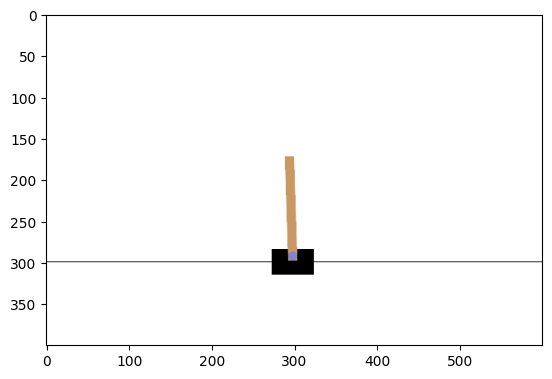

In [6]:
env = gym.make(id=env_name, render_mode='rgb_array')

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [7]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = env.observation_space.shape[0]
hidden_size = 32
output_size = env.action_space.n

agent = MLP(input_size, hidden_size, output_size)



In [8]:
def generate_session(env, agent, t_max=1000, video_recorder=None):
    """
    Play a full session with recording.
    Terminate when game finishes or after :t_max: steps.
    """
    total_reward = 0
    s, *_ = env.reset()
    s = torch.tensor(s, dtype=torch.float32)
    for t in range(t_max):
        # use agent to predict a vector of action probabilities for state :s:
        logits = agent(s.unsqueeze(0))
        probs = torch.softmax(logits, dim=1)[0].detach().numpy()
        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)
        
        new_s, r, done, is_truncated, info = env.step(a)
        
        # record session
        if video_recorder is not None:
            video_recorder.capture_frame()
        
        # store state, action and reward to lists
        total_reward += r
        new_s = torch.tensor(new_s, dtype=torch.float32)
        
        s = new_s
        if done:
            break
    return total_reward

In [9]:
dummy_reward = generate_session(env, agent, t_max=5)
print("reward:", dummy_reward)

reward: 5.0


/home/morph/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [10]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)

    clear_output(True)
    print("mean reward = %.3f" % (mean_reward))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range, bins=50)
    plt.legend()
    plt.grid()

    plt.show()

In [11]:
log = []

In [12]:
from collections import OrderedDict

def get_mlp_parameters(agent):
    return np.concatenate([p.detach().numpy().flatten() for p in agent.parameters()])

def set_mlp_parameters(agent, parameters):
    shapes = [p.shape for p in agent.parameters()]
    total_size = sum(np.product(s) for s in shapes)
    assert total_size == parameters.shape[0], "number of parameters should be %i but is %i" % (total_size, parameters.shape[0])
    
    split_ix = np.cumsum([np.product(s) for s in shapes])[:-1]
    split_parameters = np.split(parameters, split_ix)
    reshaped_parameters = [torch.tensor(p.reshape(s)) for p, s in zip(split_parameters, shapes)]
    
    state_dict = OrderedDict(zip(agent.state_dict().keys(), reshaped_parameters))
    agent.load_state_dict(state_dict)

In [13]:
parameters = get_mlp_parameters(agent)
set_mlp_parameters(agent, parameters)

In [14]:
t_max = 250
REWARD_WIN = 0.9 * t_max

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mean reward = 228.729


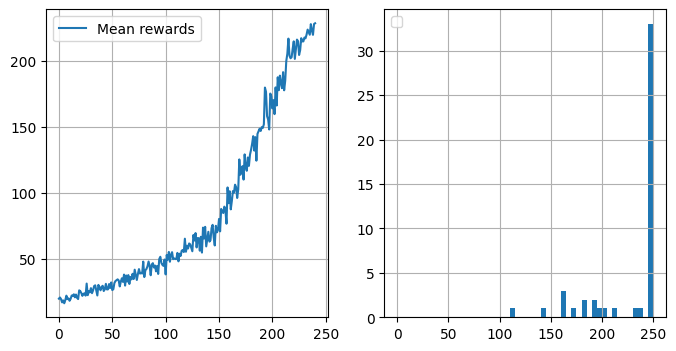

You Win!


In [15]:
# import itertools
from joblib import Parallel, delayed
import numpy as np
import warnings

npop = 48      # population size
sigma = 0.1    # noise standard deviation
alpha = 0.005  # learning rate
n_jobs = 16

def calculate_noise_reward(agent, parameters, noise, sigma, t_max):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        env = gym.make(id=env_name)
        noised_parameters = parameters + sigma * noise
        set_mlp_parameters(agent, noised_parameters)
        R = generate_session(env, agent, t_max=t_max)

    return R

def calculate_rewards_batch(agent, parameters, npop, sigma, t_max):
    N = np.random.randn(npop, parameters.shape[0])
    R = Parallel(n_jobs=n_jobs)(
        delayed(calculate_noise_reward)(agent, parameters, N[j], sigma, t_max)
        for j in range(npop)
    )
    R = np.array(R)
    return R, N

for i in range(300):
    parameters = get_mlp_parameters(agent)
    R, N = calculate_rewards_batch(agent, parameters, npop, sigma, t_max)
    A = (R - np.mean(R)) / (0.00001 + np.std(R))
    parameters = parameters + alpha / (npop * sigma) * np.dot(N.T, A)
    set_mlp_parameters(agent, parameters)
    log.append([np.mean(R)])
    if i % 10 == 0:
        show_progress(R, log, reward_range=[0, np.max(R)])
        if np.mean(R) > REWARD_WIN:
            print("You Win!")
            break

def generate_session(env, agent, t_max=1000, video_recorder=None):
    """Play a full session with recording"""
    total_reward = 0
    s, *_ = env.reset()
    s = np.array(s)
    for t in range(t_max):
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s.reshape(1, -1))[0]
        # sample action with given probabilities
        a = np.argmax(probs)
        new_s, r, done, is_truncated, info = env.step(a)
        # record session
        if video_recorder is not None:
            video_recorder.capture_frame()
        # store state, action and reward to lists
        total_reward += r
        s = np.array(new_s)
        if done:
            break
    return total_reward

In [16]:
import skvideo.io

class VideoRecorder(gym.Wrapper):
    def __init__(self, env, path=None, metadata=None, enabled=True):
        super().__init__(env)
        self.enabled = enabled
        self.metadata = metadata or {}
        self.path = path
        self.frames = []
        self.render_history = []
        self.encoder = None

    def capture_frame(self):
        frame = self.env.render()
        self.frames.append(frame)

    def close(self):
        try:
            if self.encoder is not None:
                self.encoder.close()
                self.encoder = None
            if self.path:
                if self.frames:
                    skvideo.io.vwrite(self.path, self.frames)
                self.frames = []
        except Exception as e:
            print(f"Error when closing video recorder: {e}")

    @property
    def functional(self):
        """Returns if the video recorder is functional, is enabled and not closed."""
        return self.enabled and not self.closed

In [17]:
# Record sessions
# from gym.wrappers.monitoring.video_recorder import VideoRecorder

env = gym.make(env_name, render_mode='rgb_array')
env_monitor = VideoRecorder(env, path="videos/video.mp4")
env_monitor.enabled = True

rewards = []
for i in range(1):
    reward = generate_session(env, agent, t_max, video_recorder=env_monitor)
    rewards.append(reward)
    print(f"Session {i+1}: reward={reward:.2f}")

env_monitor.close()
print(f"Average reward: {np.mean(rewards):.2f}")

/home/morph/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Session 1: reward=250.00
Average reward: 250.00
